https://www.kaggle.com/datasets/muhammetvarl/laptop-price

In [1]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"../data/regression/laptop_price - dataset.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Company              1275 non-null   object 
 1   Product              1275 non-null   object 
 2   TypeName             1275 non-null   object 
 3   Inches               1275 non-null   float64
 4   ScreenResolution     1275 non-null   object 
 5   CPU_Company          1275 non-null   object 
 6   CPU_Type             1275 non-null   object 
 7   CPU_Frequency (GHz)  1275 non-null   float64
 8   RAM (GB)             1275 non-null   int64  
 9   Memory               1275 non-null   object 
 10  GPU_Company          1275 non-null   object 
 11  GPU_Type             1275 non-null   object 
 12  OpSys                1275 non-null   object 
 13  Weight (kg)          1275 non-null   float64
 14  Price (Euro)         1275 non-null   float64
dtypes: float64(4), int64(1), object(10)
me

In [4]:
df.describe()

,Inches,CPU_Frequency (GHz),RAM (GB),Weight (kg),Price (Euro)
count,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000
mean,15.022902,2.302980,8.440784,2.040525,1134.969059
std,1.429470,0.503846,5.097809,0.669196,700.752504
min,10.100000,0.900000,2.000000,0.690000,174.000000
25%,14.000000,2.000000,4.000000,1.500000,609.000000
50%,15.600000,2.500000,8.000000,2.040000,989.000000
75%,15.600000,2.700000,8.000000,2.310000,1496.500000
max,18.400000,3.600000,64.000000,4.700000,6099.000000


In [5]:
df.select_dtypes(include=[np.object_]).describe()

,Company,Product,TypeName,ScreenResolution,CPU_Company,CPU_Type,Memory,GPU_Company,GPU_Type,OpSys
count,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275
unique,19,618,6,40,3,93,39,4,106,9
top,Dell,XPS 13,Notebook,Full HD 1920x1080,Intel,Core i5 7200U,256GB SSD,Intel,HD Graphics 620,Windows 10
freq,291,30,707,505,1214,193,412,704,280,1048


In [6]:
class PreprocessingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass 
    
    def fit(self, X=None, y=None):
        return self

    def transform(self, X: pd.DataFrame, y: pd.Series=None):
        X_ = X.copy()
        X_.drop(columns='Product', inplace=True)
        X_ = self._rename_columns(X_)
        X_ = pd.concat((X_.drop(columns='screenresolution'), self._parse_screen_resolution(X_.screenresolution)), axis=1)
        X_.drop(columns='h', inplace=True)
        X_ = pd.concat((X_.drop(columns='memory'), self._parse_memory(X_.memory)), axis=1)
        return X_.sort_index(axis=1)

    def _parse_memory(self, data: pd.Series) -> pd.DataFrame:
        data_ = pd.DataFrame(data.copy())
        cols = {'SSD': 0, 'HDD': 0, 'Flash Storage': 0, 'Hybrid': 0}
        
        for column, value in cols.items():
            data_[column] = value
            
        for index in data_.index:
            new_values = self._parse_memory_row(data_.loc[index].memory)
            data_.loc[index, new_values.keys()] = new_values.values()
        return data_.drop(columns='memory')

    @staticmethod
    def _rename_columns(data: pd.DataFrame) -> pd.DataFrame:
        new_colnames = []
        for col in data.columns:
            col = col.lower().replace(' ', '_')
            col = col.lower().replace(')', '')
            col = col.replace('(', '_')
            new_colnames.append(col)
        data.columns = new_colnames
        return data
    
    @staticmethod
    def _parse_screen_resolution(data: pd.Series) -> pd.DataFrame:
        data = pd.DataFrame(data)
        data['touchscreen'] = data.screenresolution.apply(lambda x: 'Touchscreen' in x)
        data['retina'] = data.screenresolution.apply(lambda x: 'Retina' in x)
        data['ips'] = data.screenresolution.apply(lambda x: 'IPS' in x and 'Retina' not in x)
        data['w'] = data.screenresolution.apply(lambda x: x.rsplit('x', maxsplit=1)[0].rsplit(' ', maxsplit=1)[-1]).astype(np.int64)
        data['h'] = data.screenresolution.apply(lambda x: x.rsplit('x', maxsplit=1)[1]).astype(np.int64)
        data.drop(columns='screenresolution', inplace=True)
        return data 
    
    @staticmethod
    def _parse_memory_row(row: str) -> dict:
        memory_type = {'SSD': 0, 'HDD': 0, 'Flash Storage': 0, 'Hybrid': 0}
        mem = row.split(' +  ')
        for m in mem:
            m = m.split(' ', maxsplit=1)
            memory_type[m[-1]] += float(m[0][:-2]) * (1024 if  m[0][-2:]== 'TB' else 1)

        return memory_type
        

In [7]:
class ObjectTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, object_columns: list | tuple, target_column: str):
        self.object_columns = object_columns
        self.target_column = target_column
    
    def fit(self, X: pd.DataFrame, y: pd.Series=None):
        self.numeric_features = [col for col in X.columns if col not in self.object_columns]

        X_with_target = pd.concat((X, y), axis=1)
        
        self.ohe_cols = [object_col for object_col in self.object_columns 
                         if X[object_col].nunique() <= 4]
        
        self.ohe_named_cols = sorted([f'{col}_{value}' 
                               for col in self.ohe_cols 
                               for value in X_with_target[col].unique()])
        
        for col in self.ohe_cols:
            for name in self.ohe_named_cols:
                if name.startswith(col):
                    self.ohe_named_cols.remove(name)
                    break

        self.mte_cols = list(set(self.object_columns) - set(self.ohe_cols))


        self.map_mte = {col: X_with_target.groupby(col)[self.target_column].mean()
                    for col in self.mte_cols}
        

        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        
        for col in self.ohe_cols:
            dm = pd.get_dummies(X_[col], prefix=col)
            dm = dm.sort_index(axis=1)
            dm = dm.drop(dm.columns[0], axis=1)
            X_ = pd.concat((X_, dm), axis=1)
            X_.drop(columns=col, inplace=True)

        extra_cols = [col for col in X_.columns 
                      if col not in self.ohe_named_cols
                      and
                      col not in self.numeric_features
                      and
                      col not in self.mte_cols]
        
        missing_cols = [col for col in self.ohe_named_cols
                        if col not in X_.columns]

        X_.drop(columns=extra_cols, inplace=True)
        if missing_cols:
            for col in missing_cols:
                X_[col] = 0


        for col in self.mte_cols:
            X_[col] = X_[col].map(self.map_mte[col])
            mean_value = X_[col].mean() # if an unknow category is received
            X_[col] = X_[col].fillna(mean_value)
            
        return X_.sort_index(axis=1)
    
    def fit_transform(self, X: pd.DataFrame, y: pd.Series = None):
        self.fit(X, y)
        return self.transform(X, y)



In [8]:
class IgnoreYTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, columns):
        self.transformer = transformer
        self.columns = columns

    def fit(self, X, y=None):
        self.transformer.fit(X[self.columns])
        return self

    def transform(self, X):
        X_ = X.copy()
        X_[self.columns] = X_[self.columns].astype(np.float64)
        transformed_cols = self.transformer.transform(X_[self.columns])
        X_.loc[:, self.columns] = transformed_cols
        return X_

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [9]:
a = PreprocessingTransformer()
df = a.transform(df)

In [10]:
df.select_dtypes(include=[np.object_]).describe()

,company,cpu_company,cpu_type,gpu_company,gpu_type,opsys,typename
count,1275,1275,1275,1275,1275,1275,1275
unique,19,3,93,4,106,9,6
top,Dell,Intel,Core i5 7200U,Intel,HD Graphics 620,Windows 10,Notebook
freq,291,1214,193,704,280,1048,707


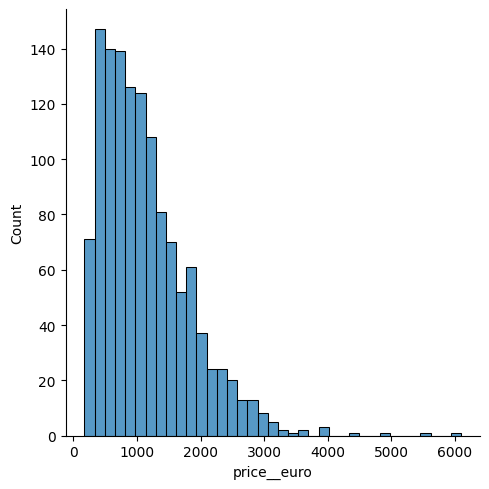

In [11]:
sns.displot(data=df, x='price__euro')

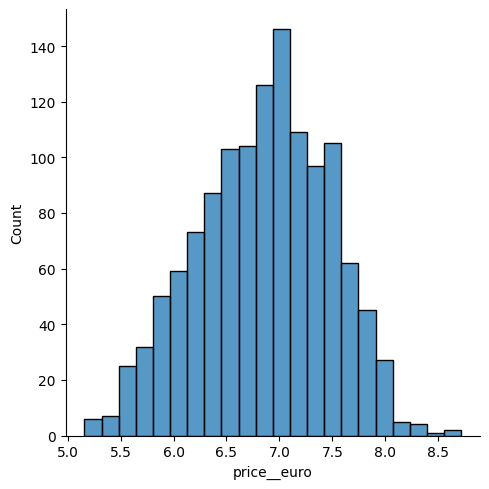

In [12]:
sns.displot(np.log(df.price__euro))

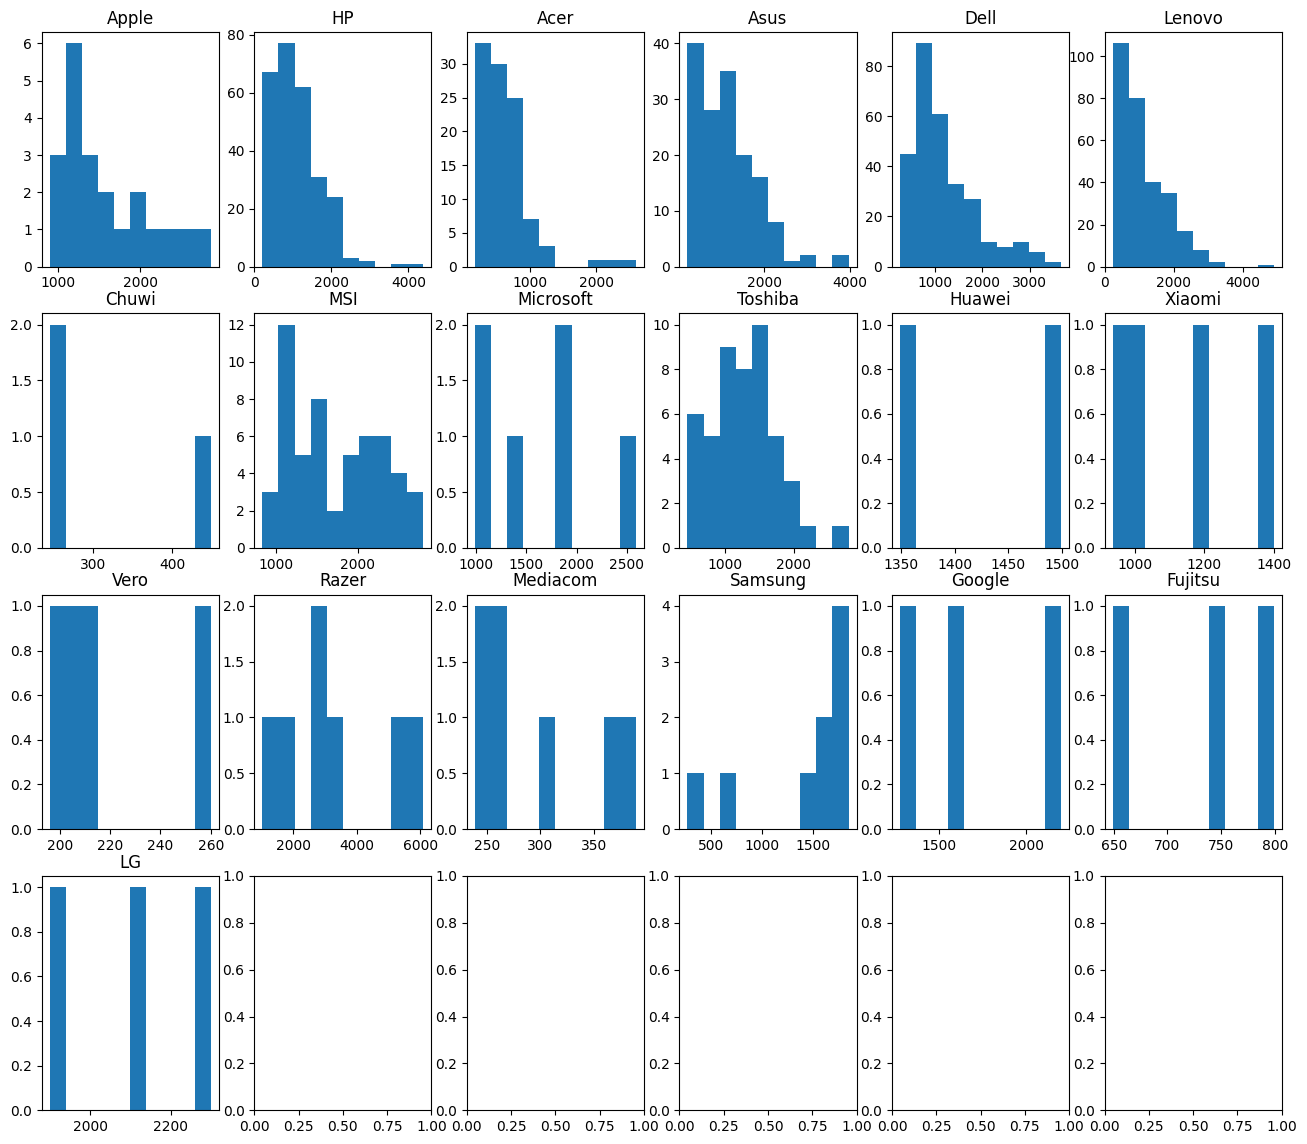

In [13]:
ig, axs = plt.subplots(figsize=(16, 14), ncols=6, nrows=df.company.nunique()//6+1)
for i, company in enumerate(df.company.unique()):
    axs[i//6,i%6].hist(df[df.company==company].price__euro)
    axs[i//6,i%6].set_title(company)

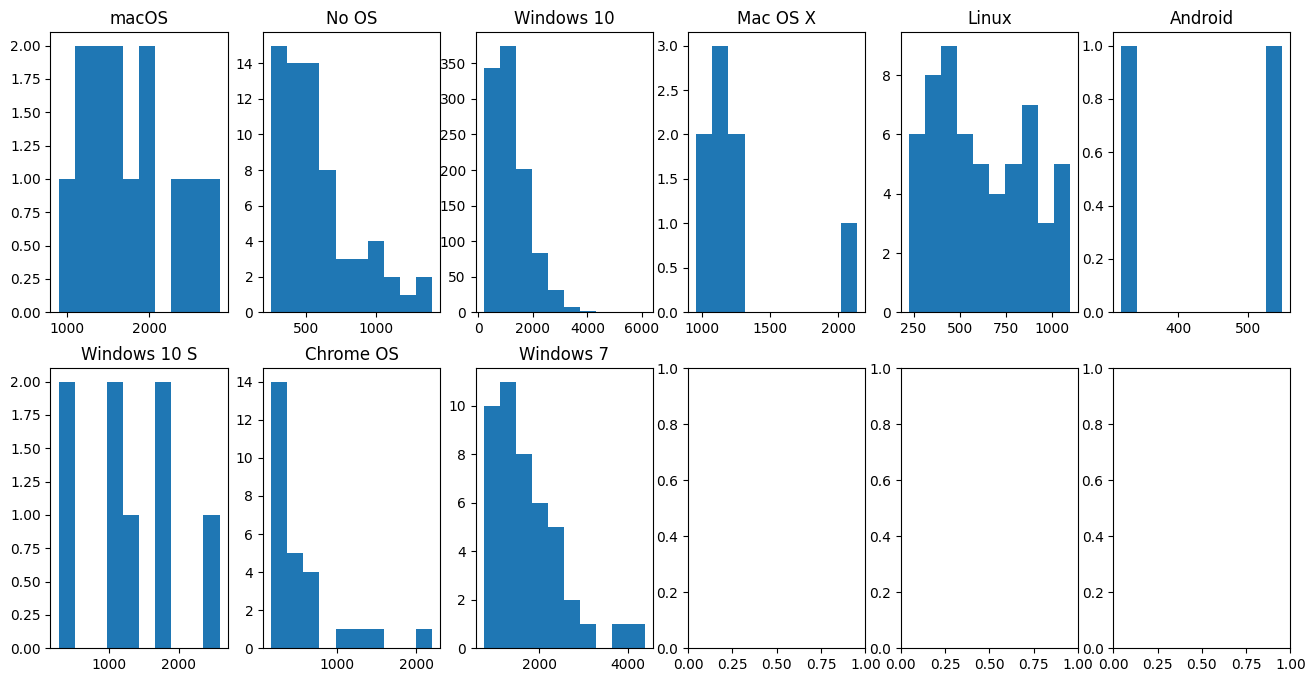

In [14]:
ig, axs = plt.subplots(figsize=(16, 8), ncols=6, nrows=df.opsys.nunique()//6+1)
for i, opsys in enumerate(df.opsys.unique()):
    axs[i//6,i%6].hist(df[df.opsys==opsys].price__euro)
    axs[i//6,i%6].set_title(opsys)

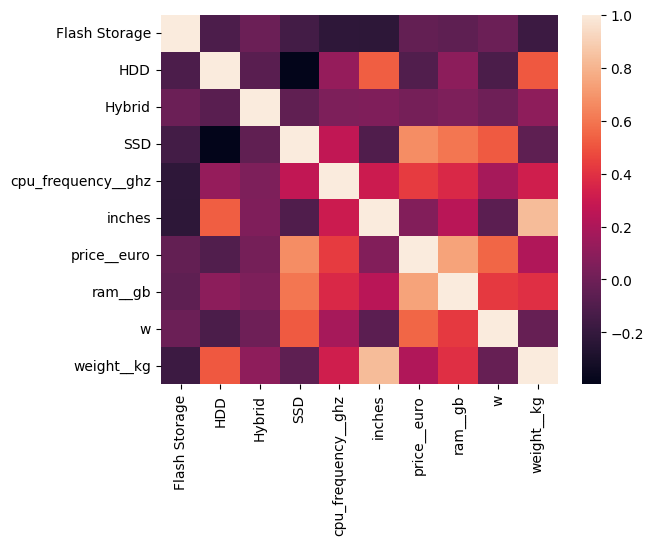

In [15]:
sns.heatmap(df.select_dtypes(np.number).corr());

In [16]:
df = pd.read_csv(r"../data/regression/laptop_price - dataset.csv")
X = df.drop('Price (Euro)', axis=1)
y = df['Price (Euro)']
y = np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=26)

In [17]:
object_cols = ['company', 'typename', 'cpu_company', 'cpu_type', 'gpu_company',
               'gpu_type', 'opsys']

numeric_cols = ['company', 'typename', 'inches', 'cpu_type', 'cpu_frequency__ghz',
                'ram__gb', 'gpu_type', 'opsys', 'weight__kg', 'w', 'SSD', 'HDD',
                'Flash Storage', 'Hybrid']

In [18]:
alphas = np.linspace(0.01, 10, 50)

lasso_pipeline = Pipeline(steps=[
    ('preprocessing_transformer', PreprocessingTransformer()),
    ('object_transformer', ObjectTransformer(object_columns=object_cols, target_column='Price (Euro)')),
    ('standart_scaler', IgnoreYTransformer(StandardScaler(), numeric_cols)),
    ('lasso_model', Lasso())
])


searcher = GridSearchCV(lasso_pipeline, param_grid=[{'lasso_model__alpha': alphas}], scoring="neg_root_mean_squared_error", cv=6, n_jobs=-1)
searcher.fit(X_train, y_train)

lasso_pipeline.set_params(**searcher.best_params_)
lasso_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing_transformer', PreprocessingTransformer()),
                ('object_transformer',
                 ObjectTransformer(object_columns=['company', 'typename',
                                                   'cpu_company', 'cpu_type',
                                                   'gpu_company', 'gpu_type',
                                                   'opsys'],
                                   target_column='Price (Euro)')),
                ('standart_scaler',
                 IgnoreYTransformer(columns=['company', 'typename', 'inches',
                                             'cpu_type', 'cpu_frequency__ghz',
                                             'ram__gb', 'gpu_type', 'opsys',
                                             'weight__kg', 'w', 'SSD', 'HDD',
                                             'Flash Storage', 'Hybrid'],
                                    transformer=StandardScaler())),
                ('lasso_model', Lasso(alpha=np.float64(0.01)))])

In [19]:
alphas = np.linspace(0.01, 10, 50)

ridge_pipeline = Pipeline(steps=[
    ('preprocessing_transformer', PreprocessingTransformer()),
    ('object_transformer', ObjectTransformer(object_columns=object_cols, target_column='Price (Euro)')),
    ('standart_scaler', IgnoreYTransformer(StandardScaler(), numeric_cols)),
    ('ridge_model', Ridge())
])


searcher = GridSearchCV(ridge_pipeline, param_grid=[{'ridge_model__alpha': alphas}], scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
searcher.fit(X_train, y_train)

ridge_pipeline.set_params(**searcher.best_params_)
ridge_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing_transformer', PreprocessingTransformer()),
                ('object_transformer',
                 ObjectTransformer(object_columns=['company', 'typename',
                                                   'cpu_company', 'cpu_type',
                                                   'gpu_company', 'gpu_type',
                                                   'opsys'],
                                   target_column='Price (Euro)')),
                ('standart_scaler',
                 IgnoreYTransformer(columns=['company', 'typename', 'inches',
                                             'cpu_type', 'cpu_frequency__ghz',
                                             'ram__gb', 'gpu_type', 'opsys',
                                             'weight__kg', 'w', 'SSD', 'HDD',
                                             'Flash Storage', 'Hybrid'],
                                    transformer=StandardScaler())),
                ('ridge_model', Ridge(alpha=np.float64(10.0)))])

In [20]:
param_grid = {
    "decision_tree_model__max_depth": list(range(5, 46, 5)),
    "decision_tree_model__min_samples_split": list(range(5, 60, 10)),
    "decision_tree_model__min_impurity_decrease": [0, 0.1, 0.2, 0.3],
    "decision_tree_model__max_leaf_nodes": list(range(10, 41, 10))
}

dicision_tree_pipeline = Pipeline(steps=[
    ('preprocessing_transformer', PreprocessingTransformer()),
    ('object_transformer', ObjectTransformer(object_columns=object_cols, target_column='Price (Euro)')),
    ('standart_scaler', IgnoreYTransformer(StandardScaler(), numeric_cols)),
    ('decision_tree_model', DecisionTreeRegressor())
])


searcher = GridSearchCV(dicision_tree_pipeline, param_grid=param_grid, scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
searcher.fit(X_train, y_train)

dicision_tree_pipeline.set_params(**searcher.best_params_)
dicision_tree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing_transformer', PreprocessingTransformer()),
                ('object_transformer',
                 ObjectTransformer(object_columns=['company', 'typename',
                                                   'cpu_company', 'cpu_type',
                                                   'gpu_company', 'gpu_type',
                                                   'opsys'],
                                   target_column='Price (Euro)')),
                ('standart_scaler',
                 IgnoreYTransformer(columns=['company', 'typename', 'inches',
                                             'cpu_type', 'cpu_frequency__ghz',
                                             'ram__gb', 'gpu_type', 'opsys',
                                             'weight__kg', 'w', 'SSD', 'HDD',
                                             'Flash Storage', 'Hybrid'],
                                    transformer=StandardScaler())),
                ('decision_tree_model',
                 DecisionTreeRegressor(max_depth=15, max_leaf_nodes=40,
                                       min_impurity_decrease=0,
                                       min_samples_split=45))])

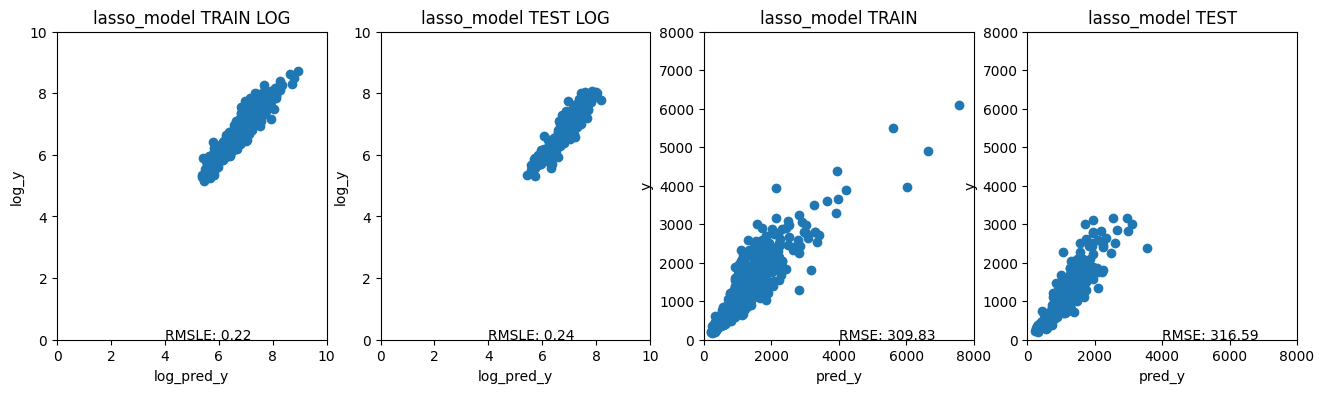

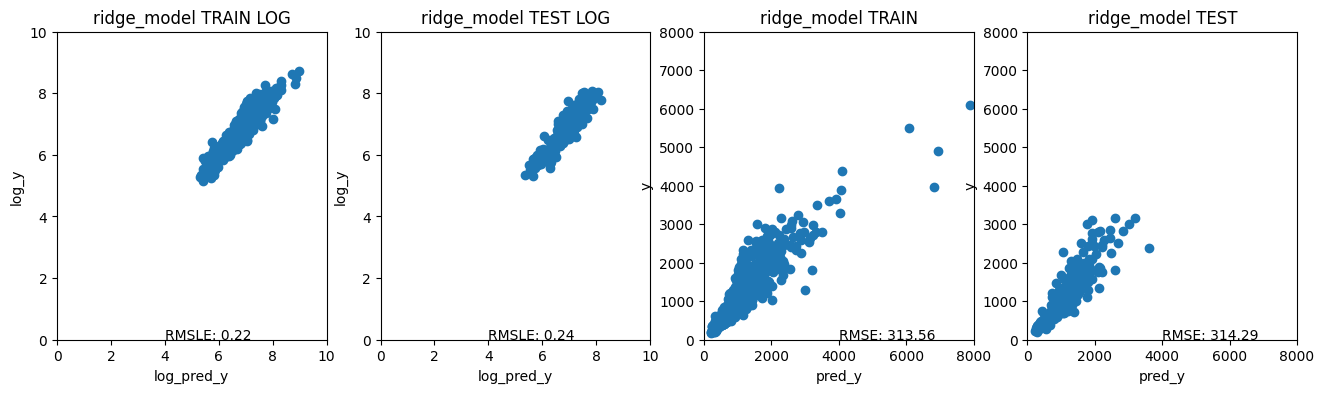

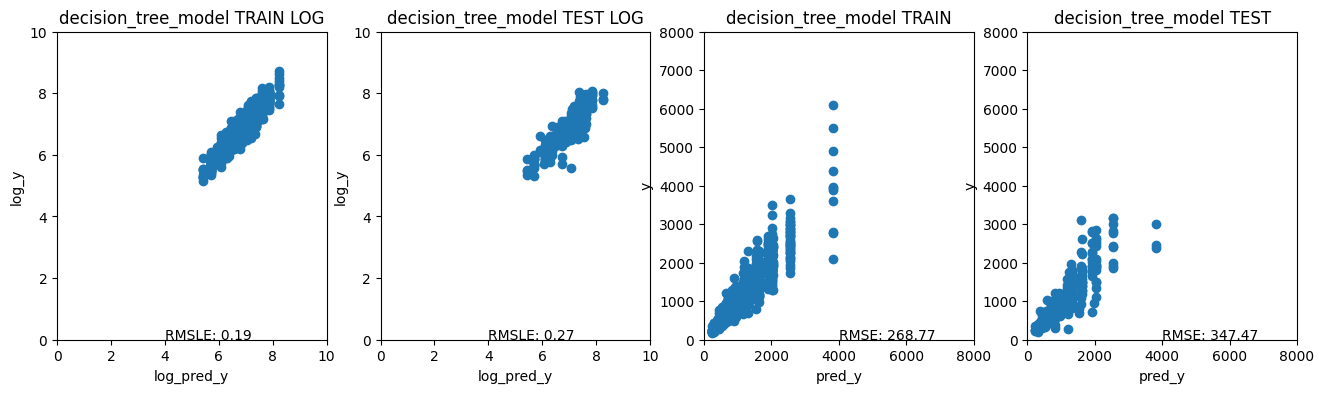

In [21]:
models = [lasso_pipeline, ridge_pipeline, dicision_tree_pipeline]
for model in models:
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_rmsle = root_mean_squared_error(y_train, y_pred_train)
    test_rmsle = root_mean_squared_error(y_test, y_pred_test)

    train_rmse = root_mean_squared_error(np.exp(y_train), np.exp(y_pred_train))
    test_rmse = root_mean_squared_error(np.exp(y_test), np.exp(y_pred_test))

    fig, axs = plt.subplots(figsize=(16, 4), ncols=4)

    axs[0].scatter(y_pred_train, y_train)
    axs[0].set_title(tuple(model.named_steps.keys())[-1] + ' TRAIN LOG')
    axs[0].set_ylabel("log_y")
    axs[0].set_xlabel("log_pred_y")
    axs[0].set_xlim(0, 10)
    axs[0].set_ylim(0, 10)
    axs[0].text(4, 0, f'RMSLE: {round(train_rmsle, 2)}')

    axs[1].scatter(y_pred_test, y_test)
    axs[1].set_title(tuple(model.named_steps.keys())[-1] + ' TEST LOG')
    axs[1].set_ylabel("log_y")
    axs[1].set_xlabel("log_pred_y")
    axs[1].set_xlim(0, 10)
    axs[1].set_ylim(0, 10)
    axs[1].text(4, 0, f'RMSLE: {round(test_rmsle, 2)}')

    axs[2].scatter(np.exp(y_pred_train), np.exp(y_train))
    axs[2].set_title(tuple(model.named_steps.keys())[-1] + ' TRAIN')
    axs[2].set_ylabel("y")
    axs[2].set_xlabel("pred_y")
    axs[2].set_xlim(0, 8_000)
    axs[2].set_ylim(0, 8_000)
    axs[2].text(4000, 0, f'RMSE: {round(train_rmse, 2)}')

    axs[3].scatter(np.exp(y_pred_test), np.exp(y_test))
    axs[3].set_title(tuple(model.named_steps.keys())[-1] + ' TEST')
    axs[3].set_ylabel("y")
    axs[3].set_xlabel("pred_y")
    axs[3].set_xlim(0, 8_000)
    axs[3].set_ylim(0, 8_000)
    axs[3].text(4000, 0, f'RMSE: {round(test_rmse, 2)}')
    